# M2M PLIMS Data Access Testing

#### Intro
Starting with the first deployment of the Coastal Pioneer Mid-Atlantic Bight (MAB) Array, OOI collected data from a plankton imaging instrument (McLane Research Labs Imaging Flow Cytobot) deployed at 7 meters depth on the near-surface instrument frame. The introduction of a new instrument to the physical OOI infrastructure required new parsing code and metadata to ingest the data into the OOI Cyberinfrastructure. Once ingested, the data will be available for machine-to-machine (M2M) download from OOI's THREDDS server and then pushed to Data Explorer on a near-real-time basis.

#### Purpose
Telemetered data from the first PLIMS deployment on Central Surface Mooring has been ingested into the Dev0 development platform where the relevant parsers are being tested. After the parameters and relevant metadata were decided upon, test NetCDFs were created for review to confirm that the parsers could create a valid and accurate dataset. This data pathway from ingested data to datasets asynchronously compiled on demand now must be tested from the perspective of a data user.

#### Objectives:

* Test Output: Request HDR science and engineering datasets with different request parameters.
* Dataset Review: Look for incorrect data values, types or metadata to provide feedback to CI. 

#### Supporting tools
If you want to run this notebook as-is, you will need to clone A. Reed's [ooinet repo](https://github.com/reedan88/OOINet) to your local machine and install it as a local dev repo (which adds it to your base path). You'll also need the [ooi_data_explorations repo](https://github.com/oceanobservatories/ooi-data-explorations). Lastly, you'll want to install the ```ioos_qc``` [python package](https://github.com/ioos/ioos_qc). 


In [1]:
# Import libraries
import os
import re
import gc
import io
import ast
import netrc
import pandas as pd
import numpy as np
import xarray as xr
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")
import glob

# Import dask
import dask
from dask.diagnostics import ProgressBar

# Import pyplot and show plots inline
import matplotlib.pyplot as plt
%matplotlib inline 

Import the M2M tool

In [2]:
from ooinet import M2M
from ooinet.Instrument.common import process_file

Import the relevant ooi_data_explorations tools

In [3]:
from ooi_data_explorations.combine_data import combine_datasets
from ooi_data_explorations.common import get_vocabulary

---
## Request and load the data
Sub in ooinet-dev0-west.intra.oceanobservatories.org into the avaialbe API urls


In [4]:
for key in M2M.URLS:
    url = M2M.URLS.get(key)
    if "opendap" in url:
        M2M.URLS[key] = re.sub("opendap", "opendap-dev0-west.intra", url)
    else:
        M2M.URLS[key] = re.sub("ooinet","ooinet-dev0-west.intra", url)

Sub in dev0 OOINet credentials from netrc file

In [5]:
try:
    nrc = netrc.netrc()
    M2M.AUTH = nrc.authenticators('ooinet-dev0-west.intra.oceanobservatories.org')
    M2M.login, M2M.password = M2M.AUTH[0], M2M.AUTH[2]
    if M2M.AUTH is None:
        raise RuntimeError(
            'No entry found for machine ``ooinet-dev0-west.intra.oceanobservatories.org`` in the .netrc file')
except FileNotFoundError as e:
    raise OSError(e, os.strerror(e.errno), os.path.expanduser('~'))

Search the Dev1 server for available datasets

In [6]:
M2M.URLS

{'data': 'https://ooinet-dev0-west.intra.oceanobservatories.org/api/m2m/12576/sensor/inv',
 'anno': 'https://ooinet-dev0-west.intra.oceanobservatories.org/api/m2m/12580/anno/find',
 'vocab': 'https://ooinet-dev0-west.intra.oceanobservatories.org/api/m2m/12586/vocab/inv',
 'asset': 'https://ooinet-dev0-west.intra.oceanobservatories.org/api/m2m/12587',
 'deploy': 'https://ooinet-dev0-west.intra.oceanobservatories.org/api/m2m/12587/events/deployment/inv',
 'preload': 'https://ooinet-dev0-west.intra.oceanobservatories.org/api/m2m/12575/parameter',
 'cal': 'https://ooinet-dev0-west.intra.oceanobservatories.org/api/m2m/12587/asset/cal',
 'fileServer': 'https://opendap-dev0-west.intra.oceanobservatories.org/thredds/fileServer/',
 'dodsC': 'https://opendap-dev0-west.intra.oceanobservatories.org/thredds/dodsC/',
 'goldCopy': 'https://thredds.dataexplorer.oceanobservatories.org/thredds/catalog/ooigoldcopy/public/',
 'goldCopy_fileServer': 'https://thredds.dataexplorer.oceanobservatories.org/thre

In [7]:
ds_df = M2M.search_datasets(array="CP10CNSM")
ds_df.reset_index(inplace=True)
# ds_df

Searching https://ooinet-dev0-west.intra.oceanobservatories.org/api/m2m/12576/sensor/inv/CP10CNSM


Find the available datastreams for a given **refdes**

In [ ]:
# url = ds_df["url"][0]
# url = "/".join((url, 'telemetered', 'plims_a_hdr_instrument'))
# # Query the preload data
# preload_data = M2M.get_api(url)
# preload_data

NOT FOUND


In [8]:
datastreams = M2M.get_datastreams("CP10CNSM-RID27-07-PLIMSA000")
datastreams

,refdes,method,stream
0,CP10CNSM-RID27-07-PLIMSA000,recovered_host,plims_a_adc_instrument
1,CP10CNSM-RID27-07-PLIMSA000,recovered_host,plims_a_hdr_engineering
2,CP10CNSM-RID27-07-PLIMSA000,recovered_host,plims_a_hdr_instrument
3,CP10CNSM-RID27-07-PLIMSA000,telemetered,plims_a_adc_instrument
4,CP10CNSM-RID27-07-PLIMSA000,telemetered,plims_a_hdr_engineering
5,CP10CNSM-RID27-07-PLIMSA000,telemetered,plims_a_hdr_instrument


In [9]:
# Define a generic preprocessing routine. Do NOT use any of the ooi_data_explorations "process_instrument" methods. We want to be comparing "apples-to-apples" 
def preprocess(ds):
    ds = process_file(ds)
    return ds

In [10]:
# Define function to change primary dimension to the sample start timestamp
def swap_timestamps(ds):
    """
    Swaps the timestamps from the host to the instrument timestamp
    for the CTDBPs
    """
    if "internal_timestamp" in ds.variables:
        # Calculate the timestamp
        inst_time = ds.internal_timestamp.to_pandas()
        attrs = ds.internal_timestamp.attrs
        # Convert the time
        inst_time = inst_time.apply(lambda x: np.datetime64(int(x), 's'))
        # Create a DataArary
        da = xr.DataArray(inst_time, attrs=attrs)
        ds['internal_timestamp'] = da
    ds = ds.set_coords(["internal_timestamp"])
    ds = ds.swap_dims({"time":"internal_timestamp"})
    ds = ds.reset_coords("time")
    ds = ds.rename_vars({"time":"host_time"})
    ds["host_time"].attrs = {
        "long_name": "DCL Timestamp",
        "comment": ("The timestamp that the instrument data as recorded by the mooring data "
                    "concentration logger (DCL)")
    }
    ds = ds.rename({"internal_timestamp":"time"})
    return ds

#### Telemetered HDR engineering data stream

In [12]:
# Setup parameters needed to request data
refdes = datastreams.refdes[4]
method = datastreams.method[4]
stream = datastreams.stream[4]

In [13]:
# Import vocabulary
site, node, sensor = refdes.split('-', 2)
vocab = get_vocabulary(site, node, sensor)

In [14]:
# Use the gold copy THREDDs datasets
thredds_url = M2M.get_thredds_url(refdes, method, stream, beginDT="2024-05-01T00:00:00.0", endDT="2024-05-15T00:00:00.0")
# Get the THREDDs catalog
thredds_catalog = M2M.get_thredds_catalog(thredds_url)
thredds_catalog = [x for x in thredds_catalog if "blank" not in x]

# Clean the THREDDs catalog
sensor_files, ancillary_files = M2M.clean_catalog(thredds_catalog, stream)

# Generate the urls to access and load the data
sensor_files = [re.sub("catalog.html\?dataset=", M2M.URLS["dodsC"], file) for file in sensor_files]



Waiting for request to process
Waiting for request to process
Waiting for request to process
Waiting for request to process
Waiting for request to process
Waiting for request to process


In [15]:
# Load the data
with ProgressBar():
    # data_hdreng = xr.open_mfdataset(sensor_files, parallel=True, preprocess=preprocess)
    data_hdreng = xr.open_mfdataset(sensor_files, parallel=True)

[########################################] | 100% Completed | 4.88 ss


In [22]:
# Check dataset content
data_hdreng = data_hdreng.swap_dims({"obs":"time"})
print(data_hdreng.source)
data_hdreng

CP10CNSM-RID27-07-PLIMSA000-telemetered-plims_a_hdr_engineering


<xarray.Dataset> Size: 34kB
Dimensions:               (time: 83)
Coordinates:
    obs                   (time) int32 332B 0 1 2 3 4 5 6 ... 77 78 79 80 81 82
  * time                  (time) datetime64[ns] 664B 2024-05-01T00:25:09 ... ...
Data variables: (12/50)
    provenance            (time) |S64 5kB dask.array<chunksize=(83,), meta=np.ndarray>
    pump1_state           (time) float32 332B dask.array<chunksize=(83,), meta=np.ndarray>
    refill_debubble       (time) float32 332B dask.array<chunksize=(83,), meta=np.ndarray>
    prime_sample          (time) float32 332B dask.array<chunksize=(83,), meta=np.ndarray>
    deployment            (time) int32 332B dask.array<chunksize=(83,), meta=np.ndarray>
    alt_interval          (time) float64 664B dask.array<chunksize=(83,), meta=np.ndarray>
    ...                    ...
    alt_pmta_threshold    (time) float32 332B dask.array<chunksize=(83,), meta=np.ndarray>
    focus_motor_step_lg   (time) float64 664B dask.array<chunksize=(83,), meta=np.ndarray>
    syringes_autorun      (time) float64 664B dask.array<chunksize=(83,), meta=np.ndarray>
    bleach_rinse_ct       (time) float64 664B dask.array<chunksize=(83,), meta=np.ndarray>
    auto_start            (time) float32 332B dask.array<chunksize=(83,), meta=np.ndarray>
    sample_volume_skip    (time) float64 664B dask.array<chunksize=(83,), meta=np.ndarray>
Attributes: (12/73)
    node:                               RID27
    comment:                            
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  telemetered
    stream:                             plims_a_hdr_engineering
    ...                                 ...
    geospatial_vertical_positive:       down
    lat:                                35.94988
    lon:                                -75.11943
    DODS.strlen:                        18
    DODS.dimName:                       string18
    DODS_EXTRA.Unlimited_Dimension:     obs

In [107]:
# For logical values, check that the mean
# of values matches the expected result
# - 1 for True
# - 0 for False
data_hdreng.beads_stirrer.mean().values

array(0., dtype=float32)

In [112]:
# Check dtype for internal temperature
# This requires precision of float64 to match raw data.
print(f"Internal temperature dtype: {data_hdreng.internal_temperature.dtype}")

Internal temperature dtype: float64


In [23]:
# Check that the time variable is coming from
# internal timestamp and the raw data filename
data_hdreng["preferred_timestamp"][0].values

array(b'internal_timestamp', dtype=object)

In [ ]:
# telem_hdreng_path = os.path.abspath(os.path.join("./plims_data", f"dev0_telem_hdr_eng_{datetime.now().isoformat(timespec='seconds')}.nc"))
# telem_hdreng_path = os.path.abspath(os.path.join("./plims_data", f"dev0_telem_hdr_eng.nc"))
# telem_hdreng_path = re.sub(":", "", telem_hdreng_path)
# data_hdreng.to_netcdf(telem_hdreng_path, engine="netcdf4")

#### Telemetered HDR science data stream

In [25]:
# Setup parameters needed to request data
refdes = datastreams.refdes[5]
method = datastreams.method[5]
stream = datastreams.stream[5]

In [26]:
# Import vocabulary
site, node, sensor = refdes.split('-', 2)
vocab = get_vocabulary(site, node, sensor)

In [27]:
# Use the gold copy THREDDs datasets
thredds_url = M2M.get_thredds_url(refdes, method, stream, beginDT="2024-05-01T00:00:00.0", endDT="2024-05-15T00:00:00.0")
# Get the THREDDs catalog
thredds_catalog = M2M.get_thredds_catalog(thredds_url)
thredds_catalog = [x for x in thredds_catalog if "blank" not in x]

# Clean the THREDDs catalog
sensor_files, ancillary_files = M2M.clean_catalog(thredds_catalog, stream)

# Generate the urls to access and load the data
sensor_files = [re.sub("catalog.html\?dataset=", M2M.URLS["dodsC"], file) for file in sensor_files]

Waiting for request to process
Waiting for request to process
Waiting for request to process
Waiting for request to process
Waiting for request to process
Waiting for request to process


In [28]:
# Load the data
with ProgressBar():
    data_hdrsci = xr.open_mfdataset(sensor_files, parallel=True)

[########################################] | 100% Completed | 814.45 ms


In [115]:
# Check dataset content
data_hdrsci

<xarray.Dataset> Size: 30kB
Dimensions:              (obs: 83)
Coordinates:
  * obs                  (obs) int32 332B 0 1 2 3 4 5 6 ... 76 77 78 79 80 81 82
    time                 (obs) datetime64[ns] 664B dask.array<chunksize=(83,), meta=np.ndarray>
Data variables: (12/34)
    pmta_threshold       (obs) float32 332B dask.array<chunksize=(83,), meta=np.ndarray>
    rois_per_ml          (obs) float64 664B dask.array<chunksize=(83,), meta=np.ndarray>
    pmtb_threshold       (obs) float32 332B dask.array<chunksize=(83,), meta=np.ndarray>
    sample_speed         (obs) float32 332B dask.array<chunksize=(83,), meta=np.ndarray>
    beads_counter        (obs) float64 664B dask.array<chunksize=(83,), meta=np.ndarray>
    run_fast_factor      (obs) float64 664B dask.array<chunksize=(83,), meta=np.ndarray>
    ...                   ...
    volume_analyzed      (obs) float64 664B dask.array<chunksize=(83,), meta=np.ndarray>
    blob_gap_min         (obs) float64 664B dask.array<chunksize=(83,), meta=np.ndarray>
    blob_area_min        (obs) float64 664B dask.array<chunksize=(83,), meta=np.ndarray>
    blob_x_grow          (obs) float64 664B dask.array<chunksize=(83,), meta=np.ndarray>
    look_time            (obs) float64 664B dask.array<chunksize=(83,), meta=np.ndarray>
    sample_num           (obs) float64 664B dask.array<chunksize=(83,), meta=np.ndarray>
Attributes: (12/73)
    node:                               RID27
    comment:                            
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  telemetered
    stream:                             plims_a_hdr_instrument
    ...                                 ...
    geospatial_vertical_positive:       down
    lat:                                35.94988
    lon:                                -75.11943
    DODS.strlen:                        18
    DODS.dimName:                       string18
    DODS_EXTRA.Unlimited_Dimension:     obs

In [122]:
# Check updated parameter attributes
data_hdrsci.blob_gap_min.comment

'Minimum distance between blobs required to be separate ROIs'

In [114]:
# Check dtype for the following parameters
# These require precision of float64 to match raw data.
print(f"Internal humidity dtype: {data_hdrsci.internal_humidity.dtype}")
print(f"Run time dtype: {data_hdrsci.run_time.dtype}")
print(f"Inhibit time dtype: {data_hdrsci.inhibit_time.dtype}")

Internal humidity dtype: float64
Run time dtype: float64
Inhibit time dtype: float64


In [124]:
# For logical values, check that the mean
# of values matches the expected result
# - 1 for True
# - 0 for False
data_hdrsci.run_fast.mean().values

array(0., dtype=float32)

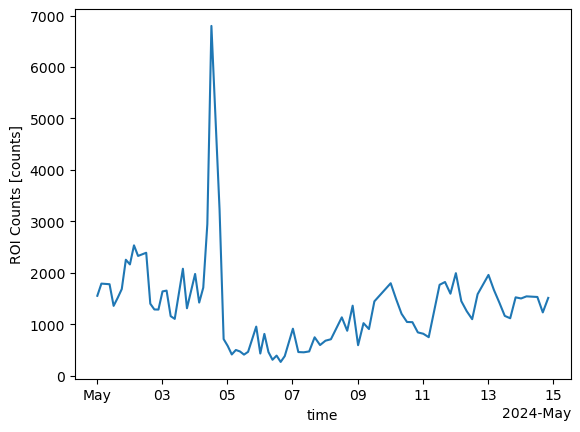

In [64]:
data_hdrsci.roi_count.plot(x="time")

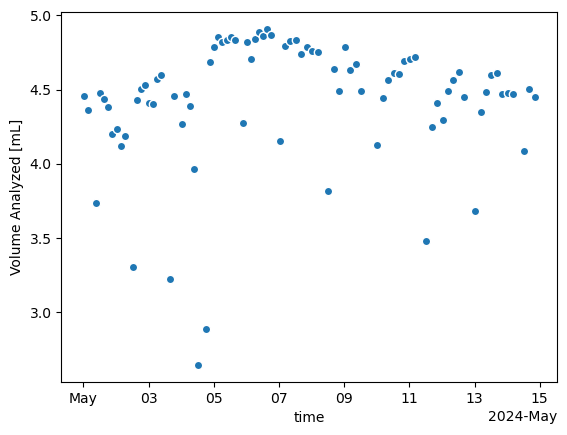

In [65]:
data_hdrsci.volume_analyzed.plot.scatter(x="time")

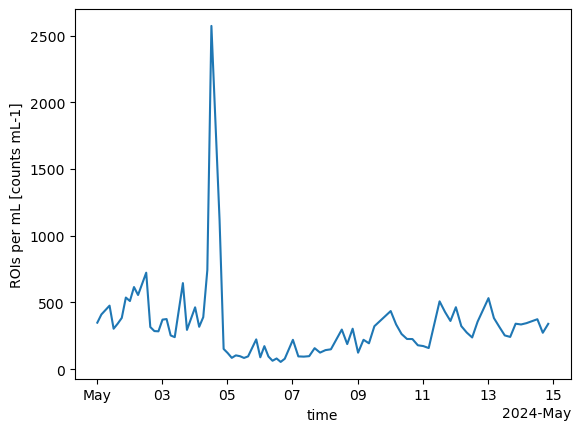

In [63]:
data_hdrsci.rois_per_ml.plot(x="time")

In [30]:
t_inhibit = data_hdrsci.inhibit_time.compute()
t_run = data_hdrsci.run_time.compute()
print(t_inhibit.head())
print(t_run.head())

<xarray.DataArray 'inhibit_time' (obs: 5)> Size: 40B
array([131.93138021, 153.61402778, 304.78836806, 126.96220486,
       136.37450521])
Coordinates:
  * obs      (obs) int32 20B 0 1 2 3 4
    time     (obs) datetime64[ns] 40B 2024-05-01T00:25:09 ... 2024-05-01T15:2...
Attributes:
    comment:      Accumulated time for which sample has not been analyzed
    units:        s
    long_name:    Total Inhibit Time
    _ChunkSizes:  83
<xarray.DataArray 'run_time' (obs: 5)> Size: 40B
array([1201.30555556, 1200.92875   , 1201.01736111, 1200.99527778,
       1200.96333333])
Coordinates:
  * obs      (obs) int32 20B 0 1 2 3 4
    time     (obs) datetime64[ns] 40B 2024-05-01T00:25:09 ... 2024-05-01T15:2...
Attributes:
    comment:      Accumulated time for which sample has been analyzed
    units:        s
    long_name:    Total Run Time
    _ChunkSizes:  83


In [31]:
calculated_look_time = t_run - t_inhibit
calculated_look_time.values == data_hdrsci.look_time.values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

Text(0, 0.5, 'Computed Look Time [s]')

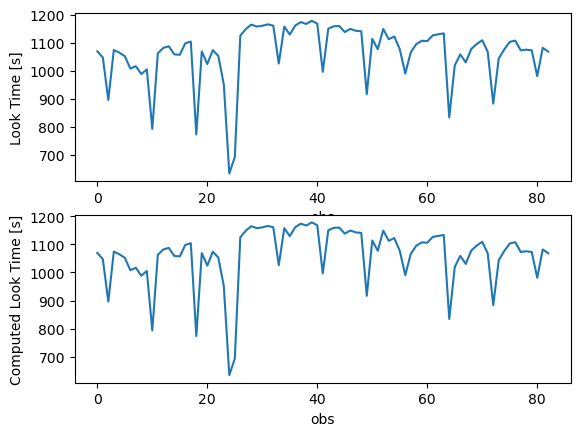

In [61]:
look_time = data_hdrsci.look_time.swap_dims({""})

fig, ax = plt.subplots(2,1)
data_hdrsci.look_time.plot(ax=ax[0])
calculated_look_time.plot(ax=ax[1])
ax[1].set_ylabel("Computed Look Time [s]")

In [ ]:
calculated_volume_analyzed = (t_run - t_inhibit)/(data_hdrsci.sample_volume - data_hdrsci.sample_speed)

In [ ]:
# data_hdrsci.to_netcdf(f"./plims_data/dev0_telemetered_hdr_sci_{datetime.now()}.nc")

#### Telemetered ADC science data stream

In [11]:
# Setup parameters needed to request data
refdes = datastreams.refdes[3]
method = datastreams.method[3]
stream = datastreams.stream[3]

In [12]:
# Import vocabulary
site, node, sensor = refdes.split('-', 2)
vocab = get_vocabulary(site, node, sensor)

In [13]:
# Use the gold copy THREDDs datasets
thredds_url = M2M.get_thredds_url(refdes, method, stream, beginDT="2024-05-01T00:00:00.0", endDT="2024-05-02T00:00:00.0")
# Get the THREDDs catalog
thredds_catalog = M2M.get_thredds_catalog(thredds_url)
thredds_catalog = [x for x in thredds_catalog if "blank" not in x]

# Clean the THREDDs catalog
sensor_files, ancillary_files = M2M.clean_catalog(thredds_catalog, stream)

# Generate the urls to access and load the data
sensor_files = [re.sub("catalog.html\?dataset=", M2M.URLS["dodsC"], file) for file in sensor_files]

Waiting for request to process
Waiting for request to process
Waiting for request to process
Waiting for request to process
Waiting for request to process
Waiting for request to process


In [14]:
# Load the data
with ProgressBar():
    data_adcsci = xr.open_mfdataset(sensor_files, parallel=True)

[########################################] | 100% Completed | 2.44 ss


In [15]:
# Check dataset content
data_adcsci

<xarray.Dataset> Size: 4MB
Dimensions:              (obs: 14338)
Coordinates:
  * obs                  (obs) int32 57kB 0 1 2 3 4 ... 14334 14335 14336 14337
    time                 (obs) datetime64[ns] 115kB dask.array<chunksize=(14338,), meta=np.ndarray>
Data variables: (12/24)
    driver_timestamp     (obs) datetime64[ns] 115kB dask.array<chunksize=(14338,), meta=np.ndarray>
    id                   (obs) |S64 918kB dask.array<chunksize=(14338,), meta=np.ndarray>
    inhibit_time_tr      (obs) float32 57kB dask.array<chunksize=(14338,), meta=np.ndarray>
    peak_b               (obs) float32 57kB dask.array<chunksize=(14338,), meta=np.ndarray>
    peak_a               (obs) float32 57kB dask.array<chunksize=(14338,), meta=np.ndarray>
    grab_time_start      (obs) float32 57kB dask.array<chunksize=(14338,), meta=np.ndarray>
    ...                   ...
    start_byte           (obs) float64 115kB dask.array<chunksize=(14338,), meta=np.ndarray>
    run_time_tr          (obs) float32 57kB dask.array<chunksize=(14338,), meta=np.ndarray>
    roi_height           (obs) float64 115kB dask.array<chunksize=(14338,), meta=np.ndarray>
    port_timestamp       (obs) datetime64[ns] 115kB dask.array<chunksize=(14338,), meta=np.ndarray>
    deployment           (obs) int32 57kB dask.array<chunksize=(14338,), meta=np.ndarray>
    preferred_timestamp  (obs) object 115kB dask.array<chunksize=(14338,), meta=np.ndarray>
Attributes: (12/73)
    node:                               RID27
    comment:                            
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  telemetered
    stream:                             plims_a_adc_instrument
    ...                                 ...
    geospatial_vertical_positive:       down
    lat:                                35.94988
    lon:                                -75.11943
    DODS.strlen:                        18
    DODS.dimName:                       string18
    DODS_EXTRA.Unlimited_Dimension:     obs

In [16]:
# Check size of the dataset
data_adcsci.nbytes

3957288

In [17]:
# Check preferred timestamp
data_adcsci.preferred_timestamp[0].values

array(b'internal_timestamp', dtype=object)

In [ ]:
# Check time values for triggers compared to sample time
print(data_adcsci.sample_timestamp[0].values) # Sample start time
print(data_adcsci.grab_time_start[0].values) # Time elapsed in seconds since the sample start time
print(data_adcsci.time[0].values) # Time of the first trigger of the sample

2024-05-01T00:25:09.000000000
9.178767
2024-05-01T00:25:18.178766848


In [ ]:
# Calculate trigger times with grab_time_start + sample_timestamp 
grab_time_s =  data_adcsci["grab_time_start"].to_numpy()*1000000000
grab_time_s = grab_time_s.astype("timedelta64[ns]")
t_trigger_computed = grab_time_s+data_adcsci["sample_timestamp"]

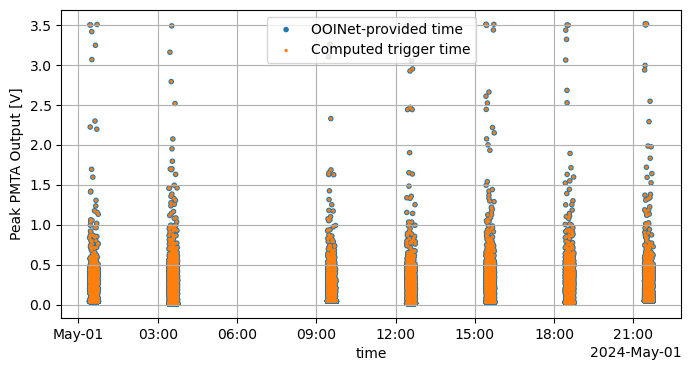

In [96]:
# Plot peak PMT A with OOINet-provided time 
# and our computed trigger time paramters
peak_a = data_adcsci.peak_a
fig = plt.figure(figsize=(8,4))
peak_a.plot.scatter(x="time", s=16, edgecolors="none", label="OOINet-provided time")
plt.scatter(t_trigger_computed, peak_a.values, s=6, edgecolors="none", label="Computed trigger time")
plt.grid()
plt.legend()

In [137]:
# Check for parameters removed from an earlier version of the ADC data stream code
parameters = ["inhibit_time", "run_time", "look_time"]
for p in parameters:
    try:
        p_is_here = data_adcsci.p
    except:
        print(f"{p} is not found in ADC science dataset")
    else:
        print(f"{p} is still in ADC science dataset")

inhibit_time is not found in ADC science dataset
run_time is not found in ADC science dataset
look_time is not found in ADC science dataset


In [97]:
# Check for standard names left in the dataset
names = list(())
for var in data_adcsci.variables:
    try:
        names.append(data_adcsci[var].standard_name)
    except:
        continue
print(f"Remaining standard names: {names}")

Remaining standard names: ['sample_timestamp', 'time']


In [ ]:
data_adcsci.roi_y[0:5000].plot.scatter(x="time")

In [ ]:
# data_adcsci.to_netcdf(f"./plims_data/dev0_telemetered_adc_sci_{datetime.now()}.nc")

#### Recovered host HDR engineering data stream

In [139]:
# Setup parameters needed to request data
refdes = datastreams.refdes[1]
method = datastreams.method[1]
stream = datastreams.stream[1]

In [140]:
# Import vocabulary
site, node, sensor = refdes.split('-', 2)
vocab = get_vocabulary(site, node, sensor)

In [141]:
# Use the gold copy THREDDs datasets
thredds_url = M2M.get_thredds_url(refdes, method, stream, beginDT="2024-05-01T00:00:00.0", endDT="2024-05-15T00:00:00.0")
# Get the THREDDs catalog
thredds_catalog = M2M.get_thredds_catalog(thredds_url)
thredds_catalog = [x for x in thredds_catalog if "blank" not in x]

# Clean the THREDDs catalog
sensor_files, ancillary_files = M2M.clean_catalog(thredds_catalog, stream)

# Generate the urls to access and load the data
sensor_files = [re.sub("catalog.html\?dataset=", M2M.URLS["dodsC"], file) for file in sensor_files]



Waiting for request to process
Waiting for request to process
Waiting for request to process
Waiting for request to process
Waiting for request to process
Waiting for request to process


In [142]:
# Load the data
with ProgressBar():
    data_hdreng2 = xr.open_mfdataset(sensor_files, parallel=True)

[########################################] | 100% Completed | 913.14 ms


In [143]:
# Check dataset content
data_hdreng2

<xarray.Dataset> Size: 34kB
Dimensions:               (obs: 83)
Coordinates:
  * obs                   (obs) int32 332B 0 1 2 3 4 5 6 ... 77 78 79 80 81 82
    time                  (obs) datetime64[ns] 664B dask.array<chunksize=(83,), meta=np.ndarray>
Data variables: (12/50)
    provenance            (obs) |S64 5kB dask.array<chunksize=(83,), meta=np.ndarray>
    pump1_state           (obs) float32 332B dask.array<chunksize=(83,), meta=np.ndarray>
    refill_debubble       (obs) float32 332B dask.array<chunksize=(83,), meta=np.ndarray>
    prime_sample          (obs) float32 332B dask.array<chunksize=(83,), meta=np.ndarray>
    deployment            (obs) int32 332B dask.array<chunksize=(83,), meta=np.ndarray>
    alt_interval          (obs) float64 664B dask.array<chunksize=(83,), meta=np.ndarray>
    ...                    ...
    alt_pmta_threshold    (obs) float32 332B dask.array<chunksize=(83,), meta=np.ndarray>
    focus_motor_step_lg   (obs) float64 664B dask.array<chunksize=(83,), meta=np.ndarray>
    syringes_autorun      (obs) float64 664B dask.array<chunksize=(83,), meta=np.ndarray>
    bleach_rinse_ct       (obs) float64 664B dask.array<chunksize=(83,), meta=np.ndarray>
    auto_start            (obs) float32 332B dask.array<chunksize=(83,), meta=np.ndarray>
    sample_volume_skip    (obs) float64 664B dask.array<chunksize=(83,), meta=np.ndarray>
Attributes: (12/73)
    node:                               RID27
    comment:                            
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             plims_a_hdr_engineering
    ...                                 ...
    geospatial_vertical_positive:       down
    lat:                                35.94988
    lon:                                -75.11943
    DODS.strlen:                        18
    DODS.dimName:                       string18
    DODS_EXTRA.Unlimited_Dimension:     obs

In [144]:
# Check for standard names left in the dataset
names = list(())
for var in data_hdreng2.variables:
    try:
        names.append(data_hdreng2[var].standard_name)
    except:
        continue
print(f"Remaining standard names: {names}")

Remaining standard names: ['internal_temperature', 'sample_timestamp', 'sample_type', 'time']


In [194]:
# For logical values, check that the mean
# of values matches the expected result
# - 1 for True
# - 0 for False
data_hdreng2.pump1_state.mean().values

array(1., dtype=float32)

In [195]:
# Check dtype for internal temperature
# This requires precision of float64 to match raw data.
print(f"Internal temperature dtype: {data_hdreng2.internal_temperature.dtype}")

Internal temperature dtype: float64


In [ ]:
# Check that the time variable is coming from
# internal timestamp and the raw data filename
data_hdreng2["preferred_timestamp"][0].values

array(b'internal_timestamp', dtype=object)

In [218]:
data_hdreng2.alt_sample_counter

<xarray.DataArray 'alt_sample_counter' (obs: 83)> Size: 664B
dask.array<open_dataset-alt_sample_counter, shape=(83,), dtype=float64, chunksize=(83,), chunktype=numpy.ndarray>
Coordinates:
  * obs      (obs) int32 332B 0 1 2 3 4 5 6 7 8 9 ... 74 75 76 77 78 79 80 81 82
    time     (obs) datetime64[ns] 664B dask.array<chunksize=(83,), meta=np.ndarray>
Attributes:
    long_name:                 Alternate Settings Sample Counter
    alternate_parameter_name:  counter_alt
    comment:                   Seawater samples run since the last sample run...
    units:                     samples
    _ChunkSizes:               83

In [ ]:
# data_hdreng2.to_netcdf(f"./plims_data/dev0_recoveredhost_hdr_eng_{datetime.now()}.nc")

#### Recovered host HDR science data stream

In [145]:
# Setup parameters needed to request data
refdes = datastreams.refdes[2]
method = datastreams.method[2]
stream = datastreams.stream[2]

In [146]:
# Import vocabulary
site, node, sensor = refdes.split('-', 2)
vocab = get_vocabulary(site, node, sensor)

In [147]:
# Use the gold copy THREDDs datasets
thredds_url = M2M.get_thredds_url(refdes, method, stream, beginDT="2024-05-01T00:00:00.0", endDT="2024-05-15T00:00:00.0")
# Get the THREDDs catalog
thredds_catalog = M2M.get_thredds_catalog(thredds_url)
thredds_catalog = [x for x in thredds_catalog if "blank" not in x]

# Clean the THREDDs catalog
sensor_files, ancillary_files = M2M.clean_catalog(thredds_catalog, stream)

# Generate the urls to access and load the data
sensor_files = [re.sub("catalog.html\?dataset=", M2M.URLS["dodsC"], file) for file in sensor_files]

Waiting for request to process
Waiting for request to process
Waiting for request to process
Waiting for request to process


In [148]:
# Load the data
with ProgressBar():
    data_hdrsci2 = xr.open_mfdataset(sensor_files, parallel=True)

[########################################] | 100% Completed | 811.57 ms


In [149]:
# Check dataset content
data_hdrsci2

<xarray.Dataset> Size: 30kB
Dimensions:              (obs: 83)
Coordinates:
  * obs                  (obs) int32 332B 0 1 2 3 4 5 6 ... 76 77 78 79 80 81 82
    time                 (obs) datetime64[ns] 664B dask.array<chunksize=(83,), meta=np.ndarray>
Data variables: (12/34)
    pmta_threshold       (obs) float32 332B dask.array<chunksize=(83,), meta=np.ndarray>
    rois_per_ml          (obs) float64 664B dask.array<chunksize=(83,), meta=np.ndarray>
    pmtb_threshold       (obs) float32 332B dask.array<chunksize=(83,), meta=np.ndarray>
    sample_speed         (obs) float32 332B dask.array<chunksize=(83,), meta=np.ndarray>
    beads_counter        (obs) float64 664B dask.array<chunksize=(83,), meta=np.ndarray>
    run_fast_factor      (obs) float64 664B dask.array<chunksize=(83,), meta=np.ndarray>
    ...                   ...
    volume_analyzed      (obs) float64 664B dask.array<chunksize=(83,), meta=np.ndarray>
    blob_gap_min         (obs) float64 664B dask.array<chunksize=(83,), meta=np.ndarray>
    blob_area_min        (obs) float64 664B dask.array<chunksize=(83,), meta=np.ndarray>
    blob_x_grow          (obs) float64 664B dask.array<chunksize=(83,), meta=np.ndarray>
    look_time            (obs) float64 664B dask.array<chunksize=(83,), meta=np.ndarray>
    sample_num           (obs) float64 664B dask.array<chunksize=(83,), meta=np.ndarray>
Attributes: (12/73)
    node:                               RID27
    comment:                            
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             plims_a_hdr_instrument
    ...                                 ...
    geospatial_vertical_positive:       down
    lat:                                35.94988
    lon:                                -75.11943
    DODS.strlen:                        18
    DODS.dimName:                       string18
    DODS_EXTRA.Unlimited_Dimension:     obs

In [150]:
# Check for standard names left in the dataset
names = list(())
for var in data_hdrsci2.variables:
    try:
        names.append(data_hdrsci2[var].standard_name)
    except:
        continue
print(f"Remaining standard names: {names}")

Remaining standard names: ['rois_per_ml', 'sample_timestamp', 'internal_humidity', 'flow_rate', 'volume_analyzed', 'look_time', 'time']


In [170]:
# Check updated parameter attributes
data_hdrsci2.blob_gap_min.comment

'Minimum distance between blobs required to be separate ROIs'

In [172]:
# Check dtype for the following parameters
# These require precision of float64 to match raw data.
print(f"Internal humidity dtype: {data_hdrsci2.internal_humidity.dtype}")
print(f"Run time dtype: {data_hdrsci2.run_time.dtype}")
print(f"Inhibit time dtype: {data_hdrsci2.inhibit_time.dtype}")

Internal humidity dtype: float64
Run time dtype: float64
Inhibit time dtype: float64


In [173]:
# For logical values, check that the mean
# of values matches the expected result
# - 1 for True
# - 0 for False
data_hdrsci2.run_fast.mean().values

array(0., dtype=float32)

In [178]:
# Check attributes of parameters updated since 21 Mar
data_hdrsci2.pmta_threshold

<xarray.DataArray 'pmta_threshold' (obs: 83)> Size: 332B
dask.array<open_dataset-pmta_threshold, shape=(83,), dtype=float32, chunksize=(83,), chunktype=numpy.ndarray>
Coordinates:
  * obs      (obs) int32 332B 0 1 2 3 4 5 6 7 8 9 ... 74 75 76 77 78 79 80 81 82
    time     (obs) datetime64[ns] 664B dask.array<chunksize=(83,), meta=np.ndarray>
Attributes:
    comment:                   Value that PMTA must exceed to trigger on PMTA
    precision:                 5
    long_name:                 PMTA Trigger Threshold
    units:                     V
    alternate_parameter_name:  pmta_trigger_threshold_daq_mcconly
    _ChunkSizes:               83

In [ ]:
# data_hdrsci.to_netcdf(f"./plims_data/dev0_recoveredhost_hdr_sci_{datetime.now()}.nc")

In [ ]:
# data_hdrsci.to_netcdf(f"./plims_data/dev0_recoveredhost_hdr_sci_{datetime.now()}.nc")

In [ ]:
# data_hdrsci.to_netcdf(f"./plims_data/dev0_recoveredhost_hdr_sci_{datetime.now()}.nc")

#### Recovered host ADC science data stream

In [49]:
# Setup parameters needed to request data
refdes = datastreams.refdes[0]
method = datastreams.method[0]
stream = datastreams.stream[0]

In [50]:
# Import vocabulary
site, node, sensor = refdes.split('-', 2)
vocab = get_vocabulary(site, node, sensor)

In [51]:
# Use the gold copy THREDDs datasets
thredds_url = M2M.get_thredds_url(refdes, method, stream, beginDT="2024-05-01T00:00:00.0", endDT="2024-05-15T00:00:00.0")
# Get the THREDDs catalog
thredds_catalog = M2M.get_thredds_catalog(thredds_url)
thredds_catalog = [x for x in thredds_catalog if "blank" not in x]

# Clean the THREDDs catalog
sensor_files, ancillary_files = M2M.clean_catalog(thredds_catalog, stream)

# Generate the urls to access and load the data
sensor_files = [re.sub("catalog.html\?dataset=", M2M.URLS["dodsC"], file) for file in sensor_files]

Waiting for request to process
Waiting for request to process
Waiting for request to process
Waiting for request to process
Waiting for request to process
Waiting for request to process
Waiting for request to process
Waiting for request to process
Waiting for request to process


In [52]:
# Load the data
with ProgressBar():
    data_adcsci2 = xr.open_mfdataset(sensor_files, parallel=True)

[########################################] | 100% Completed | 2.03 ss


In [150]:
# Check dataset content
data_adcsci2

<xarray.Dataset> Size: 38MB
Dimensions:              (obs: 136737)
Coordinates:
  * obs                  (obs) int32 547kB 0 1 2 3 ... 136734 136735 136736
    time                 (obs) datetime64[ns] 1MB dask.array<chunksize=(136737,), meta=np.ndarray>
Data variables: (12/24)
    driver_timestamp     (obs) datetime64[ns] 1MB dask.array<chunksize=(136737,), meta=np.ndarray>
    id                   (obs) |S64 9MB dask.array<chunksize=(136737,), meta=np.ndarray>
    inhibit_time_tr      (obs) float32 547kB dask.array<chunksize=(136737,), meta=np.ndarray>
    peak_b               (obs) float32 547kB dask.array<chunksize=(136737,), meta=np.ndarray>
    peak_a               (obs) float32 547kB dask.array<chunksize=(136737,), meta=np.ndarray>
    grab_time_start      (obs) float32 547kB dask.array<chunksize=(136737,), meta=np.ndarray>
    ...                   ...
    start_byte           (obs) float64 1MB dask.array<chunksize=(136737,), meta=np.ndarray>
    run_time_tr          (obs) float32 547kB dask.array<chunksize=(136737,), meta=np.ndarray>
    roi_height           (obs) float64 1MB dask.array<chunksize=(136737,), meta=np.ndarray>
    port_timestamp       (obs) datetime64[ns] 1MB dask.array<chunksize=(136737,), meta=np.ndarray>
    deployment           (obs) int32 547kB dask.array<chunksize=(136737,), meta=np.ndarray>
    preferred_timestamp  (obs) object 1MB dask.array<chunksize=(136737,), meta=np.ndarray>
Attributes: (12/73)
    node:                               RID27
    comment:                            
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             plims_a_adc_instrument
    ...                                 ...
    geospatial_vertical_positive:       down
    lat:                                35.94988
    lon:                                -75.11943
    DODS.strlen:                        18
    DODS.dimName:                       string18
    DODS_EXTRA.Unlimited_Dimension:     obs

In [ ]:
# Check preferred timestamp - this doesn't work w/ size of data array now
# data_adcsci.preferred_timestamp[0].values

KeyboardInterrupt: 

In [165]:
# Check attributes of paramaters updated since 21 Mar
data_adcsci2.roi_y

<xarray.DataArray 'roi_y' (obs: 136737)> Size: 1MB
dask.array<open_dataset-roi_y, shape=(136737,), dtype=float64, chunksize=(136737,), chunktype=numpy.ndarray>
Coordinates:
  * obs      (obs) int32 547kB 0 1 2 3 4 ... 136732 136733 136734 136735 136736
    time     (obs) datetime64[ns] 1MB dask.array<chunksize=(136737,), meta=np.ndarray>
Attributes:
    long_name:    ROI y-position
    comment:      Y-position of the upper left corner of the bounding box for...
    units:        pixels
    _ChunkSizes:  10000

In [152]:
# Check for parameters removed from an earlier version of the ADC data stream code
parameters = ["inhibit_time", "run_time", "look_time"]
for p in parameters:
    try:
        p_is_here = data_adcsci2.p
    except:
        print(f"{p} is not found in ADC science dataset")
    else:
        print(f"{p} is still in ADC science dataset")

inhibit_time is not found in ADC science dataset
run_time is not found in ADC science dataset
look_time is not found in ADC science dataset


In [154]:
# Check for standard names left in the dataset
names = list(())
for var in data_adcsci2.variables:
    try:
        names.append(data_adcsci2[var].standard_name)
    except:
        continue
print(f"Remaining standard names: {names}")

Remaining standard names: ['sample_timestamp', 'time']


In [ ]:
# data_adcsci.to_netcdf(f"./plims_data/dev0_recoveredhost_adc_sci_{datetime.now()}.nc")

## Check data accuracy

Early versions of the PLIMS NetCDFs showed inaccuracies due to a loss of precision in the float data type (32-bit) for multiple parameters. These were changed to the double data type (64-bit), but the efficacy of the updates need to be confirmed.

In [56]:
# Define routine to return any offset between the timestamp of record and sample start time
def test_time_delta(data):
    t_delta = data["internal_timestamp"] - data["sample_timestamp"]
    print(t_delta.head())
    check = (t_delta == 0)
    if check.all() == True:
        t_delta = "No offset."
    return t_delta

In [179]:
# Test for a time delta in both HDR data streams
# Telemetered
tdel_hdrsci = test_time_delta(data_hdrsci)
print(tdel_hdrsci)
tdel_hdreng = test_time_delta(data_hdreng)
print(tdel_hdreng)
# Recovered Host
tdel_hdrsci2 = test_time_delta(data_hdrsci2)
print(tdel_hdrsci2)
tdel_hdreng2 = test_time_delta(data_hdreng2)
print(tdel_hdreng2)

<xarray.DataArray (obs: 5)> Size: 40B
dask.array<getitem, shape=(5,), dtype=timedelta64[ns], chunksize=(5,), chunktype=numpy.ndarray>
Coordinates:
  * obs      (obs) int32 20B 0 1 2 3 4
    time     (obs) datetime64[ns] 40B dask.array<chunksize=(5,), meta=np.ndarray>
No offset.
<xarray.DataArray (time: 5)> Size: 40B
dask.array<getitem, shape=(5,), dtype=timedelta64[ns], chunksize=(5,), chunktype=numpy.ndarray>
Coordinates:
    obs      (time) int32 20B 0 1 2 3 4
  * time     (time) datetime64[ns] 40B 2024-05-01T00:25:09 ... 2024-05-01T15:...
No offset.
<xarray.DataArray (obs: 5)> Size: 40B
dask.array<getitem, shape=(5,), dtype=timedelta64[ns], chunksize=(5,), chunktype=numpy.ndarray>
Coordinates:
  * obs      (obs) int32 20B 0 1 2 3 4
    time     (obs) datetime64[ns] 40B dask.array<chunksize=(5,), meta=np.ndarray>
No offset.
<xarray.DataArray (obs: 5)> Size: 40B
dask.array<getitem, shape=(5,), dtype=timedelta64[ns], chunksize=(5,), chunktype=numpy.ndarray>
Coordinates:
  * obs      (o

## HDR Science data visualizations

## ADC Science data visualizations

Text(0.5, 0.98, 'Pioneer MAB Central Surface Mooring \nPlankton Imaging Sensor Peak PMT on 1 May 2025')

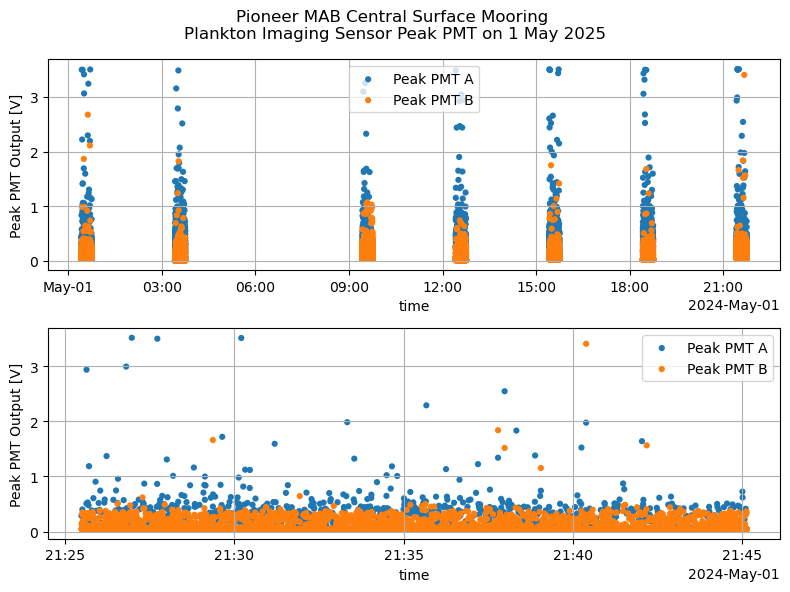

In [126]:
# Peak PMT A/B sample plot
fig, axs = plt.subplots(2, 1, figsize=(8,6), layout="tight")
# Peak PMTs during sampling on 1 May 2025
data_adcsci.peak_a.plot.scatter(x="time", s=20, edgecolors="none", ax=axs[0], label="Peak PMT A")
data_adcsci.peak_b.plot.scatter(x="time", s=20, edgecolors="none", ax=axs[0], label="Peak PMT B")
axs[0].set_ylabel("Peak PMT Output [V]")
axs[0].legend()
axs[0].grid()
# Peak PMTs during last sample on 1 May 2025
data_adcsci.peak_a[-2300:].plot.scatter(x="time", s=20, edgecolors="none", ax=axs[1], label="Peak PMT A")
data_adcsci.peak_b[-2300:].plot.scatter(x="time", s=20, edgecolors="none", ax=axs[1], label="Peak PMT B")
axs[1].set_ylabel("Peak PMT Output [V]")
axs[1].legend()
axs[1].grid()
fig.suptitle("Pioneer MAB Central Surface Mooring \nPlankton Imaging Sensor Peak PMT on 1 May 2025")

Text(0.5, 0, 'Time of Flight [s]')

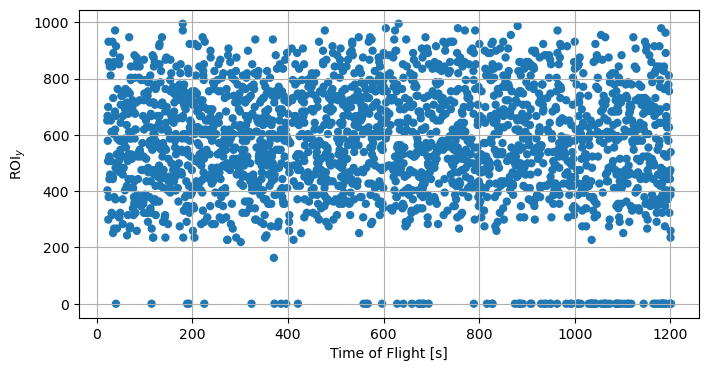

In [134]:
plt.figure(figsize=(8,4))
plt.scatter(data_adcsci["grab_time_start"][-2300:], data_adcsci["roi_y"][-2300:], edgecolors="none")
plt.grid()
plt.ylabel("ROI$_y$")
plt.xlabel("Time of Flight [s]")

Text(0.5, 0, 'Time')

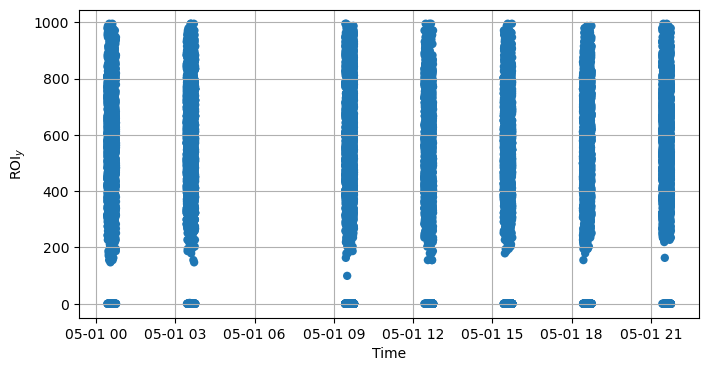

In [138]:
plt.figure(figsize=(8,4))
plt.scatter(data_adcsci["time"], data_adcsci["roi_y"], edgecolors="none")
plt.grid()
plt.ylabel("ROI$_y$")
plt.xlabel("Time")

Text(0.5, 0, 'ROI width [pixels]')

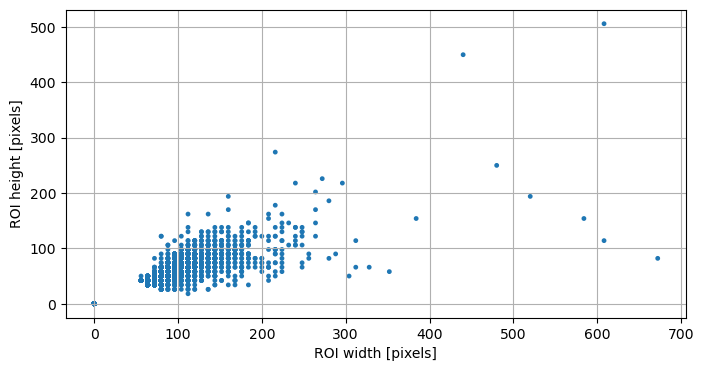

In [137]:
plt.figure(figsize=(8,4))
plt.scatter(data_adcsci["roi_width"], data_adcsci["roi_height"], edgecolors="none", s=12)
plt.grid()
plt.ylabel("ROI height [pixels]")
plt.xlabel("ROI width [pixels]")